<a href="https://colab.research.google.com/github/NicolaGabriele/progettoDeepLearning/blob/main/ProgettoDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.0 MB/s eta 0:00:00


In [3]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.8 MB/s eta 0:00:00


In [4]:
import cv2
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import f1_score
import torchvision.transforms as transforms
from torchvision import models as resnet_model
import torchvision
from torcheval.metrics import BinaryF1Score
import os
from torch.utils.data.dataset import random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(str(device) + ' is selected !')

IMAGES_DIR = '/content/drive/MyDrive/machinedeeplearning/dataset/images'
LABELS_DIR = '/content/drive/MyDrive/machinedeeplearning/dataset/masks'
TRAIN_IMGS = '/content/drive/MyDrive/machinedeeplearning/dataset/trainset/images'
TRAIN_MSKS = '/content/drive/MyDrive/machinedeeplearning/dataset/trainset/masks'
TEST_IMGS = '/content/drive/MyDrive/machinedeeplearning/dataset/testset/images'
TEST_MSKS = '/content/drive/MyDrive/machinedeeplearning/dataset/testset/masks'

cuda is selected !


#***Dataset Loading***

In [5]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, img_dir, lab_dir, train = True):
    super(Dataset, self).__init__()
    self.img_dir = img_dir
    self.lab_dir = lab_dir
    self.img_names = os.listdir(img_dir)
    self.lab_names = os.listdir(lab_dir)
    self.transform1 = torchvision.transforms.Compose(
        [torchvision.transforms.Resize((224,224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.GaussianBlur(3)]
    )

    self.transform2 = torchvision.transforms.Compose(
        [torchvision.transforms.Resize((224,224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5)]
    )
    self.transform = torchvision.transforms.Resize((224,224))
    self.train = train

  def __getitem__(self,idx):
    img_name = os.path.join(self.img_dir,self.img_names[idx])
    clas = 1 if self.img_names[idx][:2] == '00' else 0 if self.img_names[idx][:1] == '0' else 2
    mask_name = os.path.join(self.lab_dir, self.lab_names[idx])
    image = torchvision.io.read_image(img_name)/255
    mask = torchvision.io.read_image(mask_name)/255
    if self.train:
      image = self.transform1(image)
      mask = self.transform2(mask)
    else:
      image = self.transform(image)
      mask = self.transform(mask)
    return (image,mask[0],clas)

  def __len__(self):
    return len(os.listdir(self.img_dir))

In [6]:
trainset = Dataset(TRAIN_IMGS, TRAIN_MSKS, train=False)
testset = Dataset(TEST_IMGS, TEST_MSKS,train=False)

#***Segmentation Only***

##***MET-NET***

In [7]:
class DecoderBottleneckLayer(nn.Module):
    def __init__(self, in_channels, n_filters, use_transpose=True):
        super(DecoderBottleneckLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nn.LeakyReLU()

        if use_transpose:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1
                ),
                nn.BatchNorm2d(in_channels // 4),
                nn.LeakyReLU()
            )
        else:
            self.up = nn.Upsample(scale_factor=2, align_corners=True, mode="bilinear")

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.up(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x

class FFBlock(nn.Module):
    def __init__(self, channels):
        super(FFBlock, self).__init__()

        self.conv3 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1)

        self.relu3 = nn.LeakyReLU()
        self.relu1 = nn.LeakyReLU()

    def forward(self, x):
        x3 = self.conv3(x)
        x3 = self.relu3(x3)
        x1 = self.conv1(x)
        x1 = self.relu1(x1)
        out = x3 + x1

        return out

class SEBlock(nn.Module):
    def __init__(self, channel, r=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // r, bias=False),
            nn.LeakyReLU(),
            nn.Linear(channel // r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        ## Squeeze operation
        y = self.avg_pool(x).view(b, c)
        ## Excitation operation
        y = self.fc(y).view(b, c, 1, 1)
        ## Fusion operation
        y = torch.mul(x, y)
        return y

class PDFBlock(nn.Module):
    def __init__(self,in_channels, out_channels_list, kernel_size_list, dilation_list):
        super(PDFBlock, self).__init__()
        self.conv_num = len(out_channels_list)
        assert(self.conv_num == 4)
        assert(self.conv_num == len(kernel_size_list) and self.conv_num == len(dilation_list))
        pad0 = int((kernel_size_list[0] - 1) / 2 * dilation_list[0])
        pad1 = int((kernel_size_list[1] - 1) / 2 * dilation_list[1])
        pad2 = int((kernel_size_list[2] - 1) / 2 * dilation_list[2])
        pad3 = int((kernel_size_list[3] - 1) / 2 * dilation_list[3])
        self.conv_1 = nn.Conv2d(in_channels, out_channels_list[0], kernel_size = kernel_size_list[0], dilation = dilation_list[0], padding = pad0 )
        self.conv_2 = nn.Conv2d(in_channels, out_channels_list[1], kernel_size = kernel_size_list[1], dilation = dilation_list[1], padding = pad1 )
        self.conv_3 = nn.Conv2d(in_channels, out_channels_list[2], kernel_size = kernel_size_list[2], dilation = dilation_list[2], padding = pad2 )
        self.conv_4 = nn.Conv2d(in_channels, out_channels_list[3], kernel_size = kernel_size_list[3], dilation = dilation_list[3], padding = pad3 )

        out_channels  = out_channels_list[0] + out_channels_list[1] + out_channels_list[2] + out_channels_list[3]
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU())

    def forward(self, x):
        x1 = self.conv_1(x)
        x2 = self.conv_2(x)
        x3 = self.conv_3(x)
        x4 = self.conv_4(x)

        y  = torch.cat([x1, x2, x3, x4], dim=1)
        y  = self.conv_1x1(y)
        return y

class MET_Net(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(MET_Net, self).__init__()

        transformer = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_distilled_patch16_224', pretrained=True)
        resnet = resnet_model.resnet18(pretrained=True)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu

        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.patch_embed = transformer.patch_embed
        self.transformers = nn.ModuleList( [transformer.blocks[i] for i in range(12)] )

        self.conv_seq_img = nn.Conv2d(in_channels=192, out_channels=512, kernel_size=1, padding=0)
        self.se = SEBlock(channel=1024)
        self.conv2d = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0)

        self.FFBlock1 = FFBlock(channels=64)
        self.FFBlock2 = FFBlock(channels=128)
        self.FFBlock3 = FFBlock(channels=256)

        self.FFB1 = nn.ModuleList([self.FFBlock1 for i in range(6)])
        self.FFB2 = nn.ModuleList([self.FFBlock2 for i in range(4)])
        self.FFB3 = nn.ModuleList([self.FFBlock3 for i in range(2)])

        filters = [64, 128, 256, 512]

        self.decoder4 = DecoderBottleneckLayer(filters[3], filters[2])
        self.decoder3 = DecoderBottleneckLayer(filters[2], filters[1])
        self.decoder2 = DecoderBottleneckLayer(filters[1], filters[0])
        self.decoder1 = DecoderBottleneckLayer(filters[0], filters[0])

        self.final_conv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.final_relu1 = nn.LeakyReLU()
        self.final_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.final_relu2 = nn.LeakyReLU()
        self.final_conv3 = nn.Conv2d(32, n_classes, 3, padding=1)

    def forward(self, x):
        b, c, h, w = x.shape

        e0 = self.firstconv(x)
        e0 = self.firstbn(e0)
        e0 = self.firstrelu(e0)

        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        feature_cnn = self.encoder4(e3)

        emb = self.patch_embed(x)
        for i in range(12):
            emb = self.transformers[i](emb)

        feature_tf = emb.permute(0, 2, 1)
        feature_tf = feature_tf.view(b, 192, 14, 14)
        feature_tf = self.conv_seq_img(feature_tf)

        feature_cat = torch.cat((feature_cnn, feature_tf), dim=1)
        feature_att = self.se(feature_cat)
        feature_out = self.conv2d(feature_att)

        for i in range(2):
            e3 = self.FFB3[i](e3)
        for i in range(4):
            e2 = self.FFB2[i](e2)
        for i in range(6):
            e1 = self.FFB1[i](e1)

        d4 = self.decoder4(feature_out) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1

        out1 = self.final_conv1(d2)
        out1 = self.final_relu1(out1)

        out = self.final_conv2(out1)
        out = self.final_relu2(out)
        out = self.final_conv3(out)

        return out

In [8]:
model = MET_Net()
for param in model.parameters():
  if len(param.data.shape)>1:
    torch.nn.init.xavier_normal_(param.data)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:78: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_small_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:93: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Plea

##***Training***

In [9]:
class DiceLoss(nn.Module):
  def __init__(self):
    super(DiceLoss,self).__init__()

  def forward(self, predictions, targets):
    pred = torch.nn.functional.sigmoid(predictions).squeeze(dim=(1))
    #pred = torch.where(pred>=0.7, 1, 0).squeeze(dim=(1)).type(torch.uint8) #aggiustare lo squeeze
    targ = targets.type(torch.uint8)
    intersection = torch.mul(pred,targ).flatten(start_dim=1, end_dim=2).sum(dim=1)
    union = pred.flatten(start_dim=1, end_dim=2).sum(dim=1) + targ.flatten(start_dim=1, end_dim=2).sum(dim=1)
    iou = (1+2*intersection)/(1+union)
    return torch.tensor(1.0, requires_grad=True)-iou.mean()

In [10]:
#iperparameter
num_epochs = 30
batch_size = 32
learning_rate=1e-4
optimizer = torch.optim.NAdam(params=model.parameters(),lr=learning_rate)
lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,patience=15)
dataloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
loss_fn = DiceLoss()

In [11]:
def train_one_epoch(epoch_index):
    l = []

    for i, data in enumerate(dataloader):

        torch.cuda.empty_cache()
        inputs, labels, cls = data
        inputs = inputs.to('cuda')
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        #print('Batch {} loss: {:.4f}'.format(i,loss.item()))

        l.append(loss.item())

    print('Epoch {} Loss (mean): {:.4f}'.format(epoch_index, np.mean(l)))

In [12]:
model.train()
model.to('cuda')
for epoch in range(1,num_epochs+1):
  train_one_epoch(epoch)
  if epoch%1 == 0:
    torch.save(model,f'/content/drive/MyDrive/machinedeeplearning/models/model_{epoch}ep')

Epoch 1 Loss (mean): 0.8130
Epoch 2 Loss (mean): 0.7611
Epoch 3 Loss (mean): 0.6040
Epoch 4 Loss (mean): 0.5702
Epoch 5 Loss (mean): 0.5678
Epoch 6 Loss (mean): 0.5674
Epoch 7 Loss (mean): 0.5647
Epoch 8 Loss (mean): 0.5642
Epoch 9 Loss (mean): 0.5616
Epoch 10 Loss (mean): 0.5577
Epoch 11 Loss (mean): 0.5532
Epoch 12 Loss (mean): 0.5472
Epoch 13 Loss (mean): 0.5286
Epoch 14 Loss (mean): 0.5075
Epoch 15 Loss (mean): 0.4888
Epoch 16 Loss (mean): 0.4567
Epoch 17 Loss (mean): 0.4365
Epoch 18 Loss (mean): 0.4185
Epoch 19 Loss (mean): 0.4081
Epoch 20 Loss (mean): 0.3932
Epoch 21 Loss (mean): 0.3691
Epoch 22 Loss (mean): 0.3402
Epoch 23 Loss (mean): 0.3238
Epoch 24 Loss (mean): 0.3150
Epoch 25 Loss (mean): 0.2944
Epoch 26 Loss (mean): 0.2877
Epoch 27 Loss (mean): 0.2711
Epoch 28 Loss (mean): 0.2549
Epoch 29 Loss (mean): 0.2475
Epoch 30 Loss (mean): 0.2295


In [ ]:
model.to(device)
train_one_epoch(1)

Epoch 1 Loss (mean): 0.4986859874197548


In [ ]:
k = torch.randn((3,3,224,224))
model.to('cpu')
k = model(k)
k = torch.nn.functional.sigmoid(k)
k = torch.where(k>=0.6,1,0)
l = torch.rand((3,1,224,224))
l = torch.where(l>=0.6,1,0)
loss_fn(k,l)

tensor(0.5891)

##***Model Evaluation***

In [9]:
import torcheval
def evaluate(model):
  model.eval()
  thresh = 0.7
  testloader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=False)
  m = BinaryF1Score(threshold=thresh)
  prec = torcheval.metrics.BinaryPrecision(threshold=thresh)
  rec = torcheval.metrics.BinaryRecall(threshold=thresh)
  for i, data in enumerate(testloader):
    x, ytrue,cls = data
    x = x.to(device)
    ypred = model(x)
    ypred = torch.nn.functional.sigmoid(ypred)[0][0].flatten()
    m.update(ypred,ytrue[0].flatten().type(torch.uint8))
    prec.update(ypred,ytrue[0].flatten().type(torch.uint8))
    rec.update(ypred,ytrue[0].flatten().type(torch.uint8))
  return m.compute(), prec.compute(), rec.compute()


In [ ]:
models_dir = '/content/drive/MyDrive/machinedeeplearning/models/'
f1s = []
precs = []
recs = []
for model_name in os.listdir(models_dir)[:-1]:
  model = torch.load(os.path.join(models_dir,model_name))
  f1, prec, rec = evaluate(model)
  f1s.append(f1)
  precs.append(prec)
  recs.append(rec)

print(f1s)
print(precs)
print(recs)


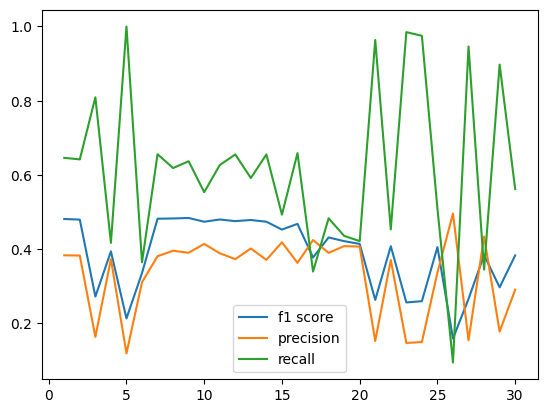

In [19]:
plt.plot(range(1,31), f1s, label='f1 score')
plt.plot(range(1,31), precs, label='precision')
plt.plot(range(1,31), recs, label = 'recall')
plt.legend()
plt.show()

In [17]:
os.listdir(models_dir)

['model_5ep',
 'model_10ep',
 'model_20ep',
 'model_30ep',
 'model_1ep',
 'model_2ep',
 'model_3ep',
 'model_4ep',
 'model_6ep',
 'model_7ep',
 'model_8ep',
 'model_9ep',
 'model_11ep',
 'model_12ep',
 'model_13ep',
 'model_14ep',
 'model_15ep',
 'model_16ep',
 'model_17ep',
 'model_18ep',
 'model_19ep',
 'model_21ep',
 'model_22ep',
 'model_23ep',
 'model_24ep',
 'model_25ep',
 'model_26ep',
 'model_27ep',
 'model_28ep',
 'model_29ep',
 '.ipynb_checkpoints']

In [ ]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
def visualize(img, model):
  prediction = model(img.unsqueeze(dim=0))
  im = torch.tensor((img*255).cpu().numpy().astype(np.uint8),dtype=torch.uint8)
  result = im
  masks = torch.where(prediction>0.5,True,False)
  result = draw_segmentation_masks(image = result,masks=masks,alpha=0.5)
  return result

In [ ]:
model = torch.load('/content/drive/MyDrive/machinedeeplearning/models/model_100ep')

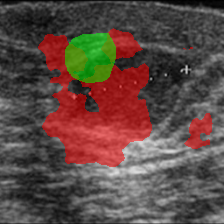

In [ ]:
model.eval()
i = np.random.randint(0,len(testset)-1)
p = model(testset[i][0].to(device).unsqueeze(dim=0))[0,0]
mask = torch.where(p>0.1,True,False)
im = torch.tensor((testset[i][0]*255).cpu().numpy().astype(np.uint8),dtype=torch.uint8)
r = draw_segmentation_masks(image = im,masks=mask,alpha=0.5,colors=[(255,0,0)])
r = draw_segmentation_masks(image = r,masks=testset[i][1].type(torch.uint8).type(torch.bool),alpha=0.5,colors=[(0,255,0)])
torchvision.transforms.ToPILImage()(r)

#***Classification Only***

##***Modifica di MET_Net***

In [ ]:
class DecoderBottleneckLayer(nn.Module):
    def __init__(self, in_channels, n_filters, use_transpose=True):
        super(DecoderBottleneckLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nn.LeakyReLU()

        if use_transpose:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1
                ),
                nn.BatchNorm2d(in_channels // 4),
                nn.LeakyReLU()
            )
        else:
            self.up = nn.Upsample(scale_factor=2, align_corners=True, mode="bilinear")

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.up(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x

class FFBlock(nn.Module):
    def __init__(self, channels):
        super(FFBlock, self).__init__()

        self.conv3 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1)

        self.relu3 = nn.LeakyReLU()
        self.relu1 = nn.LeakyReLU()

    def forward(self, x):
        x3 = self.conv3(x)
        x3 = self.relu3(x3)
        x1 = self.conv1(x)
        x1 = self.relu1(x1)
        out = x3 + x1

        return out

class SEBlock(nn.Module):
    def __init__(self, channel, r=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // r, bias=False),
            nn.LeakyReLU(),
            nn.Linear(channel // r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        ## Squeeze operation
        y = self.avg_pool(x).view(b, c)
        ## Excitation operation
        y = self.fc(y).view(b, c, 1, 1)
        ## Fusion operation
        y = torch.mul(x, y)
        return y

class PDFBlock(nn.Module):
    def __init__(self,in_channels, out_channels_list, kernel_size_list, dilation_list):
        super(PDFBlock, self).__init__()
        self.conv_num = len(out_channels_list)
        assert(self.conv_num == 4)
        assert(self.conv_num == len(kernel_size_list) and self.conv_num == len(dilation_list))
        pad0 = int((kernel_size_list[0] - 1) / 2 * dilation_list[0])
        pad1 = int((kernel_size_list[1] - 1) / 2 * dilation_list[1])
        pad2 = int((kernel_size_list[2] - 1) / 2 * dilation_list[2])
        pad3 = int((kernel_size_list[3] - 1) / 2 * dilation_list[3])
        self.conv_1 = nn.Conv2d(in_channels, out_channels_list[0], kernel_size = kernel_size_list[0], dilation = dilation_list[0], padding = pad0 )
        self.conv_2 = nn.Conv2d(in_channels, out_channels_list[1], kernel_size = kernel_size_list[1], dilation = dilation_list[1], padding = pad1 )
        self.conv_3 = nn.Conv2d(in_channels, out_channels_list[2], kernel_size = kernel_size_list[2], dilation = dilation_list[2], padding = pad2 )
        self.conv_4 = nn.Conv2d(in_channels, out_channels_list[3], kernel_size = kernel_size_list[3], dilation = dilation_list[3], padding = pad3 )

        out_channels  = out_channels_list[0] + out_channels_list[1] + out_channels_list[2] + out_channels_list[3]
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU())

    def forward(self, x):
        x1 = self.conv_1(x)
        x2 = self.conv_2(x)
        x3 = self.conv_3(x)
        x4 = self.conv_4(x)

        y  = torch.cat([x1, x2, x3, x4], dim=1)
        y  = self.conv_1x1(y)
        return y

class MET_Netv2(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(MET_Netv2, self).__init__()

        transformer = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_distilled_patch16_224', pretrained=True)
        resnet = resnet_model.resnet18(pretrained=True)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu

        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.patch_embed = transformer.patch_embed
        self.transformers = nn.ModuleList( [transformer.blocks[i] for i in range(12)] )

        self.conv_seq_img = nn.Conv2d(in_channels=192, out_channels=512, kernel_size=1, padding=0)
        self.se = SEBlock(channel=1024)
        self.conv2d = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0)

        self.FFBlock1 = FFBlock(channels=64)
        self.FFBlock2 = FFBlock(channels=128)
        self.FFBlock3 = FFBlock(channels=256)

        self.FFB1 = nn.ModuleList([self.FFBlock1 for i in range(6)])
        self.FFB2 = nn.ModuleList([self.FFBlock2 for i in range(4)])
        self.FFB3 = nn.ModuleList([self.FFBlock3 for i in range(2)])

        filters = [64, 128, 256, 512]

        self.decoder4 = DecoderBottleneckLayer(filters[3], filters[2])
        self.decoder3 = DecoderBottleneckLayer(filters[2], filters[1])
        self.decoder2 = DecoderBottleneckLayer(filters[1], filters[0])
        self.decoder1 = DecoderBottleneckLayer(filters[0], filters[0])

        self.final_conv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.final_relu1 = nn.LeakyReLU()
        self.final_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.final_relu2 = nn.LeakyReLU()
        self.final_conv3 = nn.Conv2d(32, n_classes, 3, padding=1)

        self.cls = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512,kernel_size=1),
            nn.BatchNorm2d(512),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=512, out_channels=128,kernel_size=1),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=128, out_channels=64,kernel_size=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=1,kernel_size=1),
            nn.Flatten(),
            nn.Linear(in_features=14*14, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, h, w = x.shape

        e0 = self.firstconv(x)
        e0 = self.firstbn(e0)
        e0 = self.firstrelu(e0)

        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        feature_cnn = self.encoder4(e3)

        emb = self.patch_embed(x)
        for i in range(12):
            emb = self.transformers[i](emb)

        feature_tf = emb.permute(0, 2, 1)
        feature_tf = feature_tf.view(b, 192, 14, 14)
        feature_tf = self.conv_seq_img(feature_tf)

        feature_cat = torch.cat((feature_cnn, feature_tf), dim=1)
        feature_att = self.se(feature_cat)
        feature_out = self.conv2d(feature_att)

        in_cls = feature_att.clone()

        out_cls = self.cls(in_cls)

        for i in range(2):
            e3 = self.FFB3[i](e3)
        for i in range(4):
            e2 = self.FFB2[i](e2)
        for i in range(6):
            e1 = self.FFB1[i](e1)

        d4 = self.decoder4(feature_out) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1

        out1 = self.final_conv1(d2)
        out1 = self.final_relu1(out1)

        out = self.final_conv2(out1)
        out = self.final_relu2(out)
        out = self.final_conv3(out)

        return (out,out_cls)

In [ ]:
model = MET_Netv2()
model.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:78: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_small_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:93: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

MET_Netv2(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

##***Training***

In [ ]:
class DiceAndCE(nn.Module):
  def __init__(self):
    super(DiceAndCE,self).__init__()
    self.dice = DiceLoss()
    self.ce = nn.BCELoss()


  def forward(self, predictions,  targets_segm, targets_cls):
    return self.dice(predictions[0], targets_segm) + self.ce(predictions[1].flatten(), targets_cls.type(torch.float32))


In [ ]:
#iperparameter
num_epochs = 100
batch_size = 32
learning_rate=1e-4
optimizer = torch.optim.NAdam(params=model.parameters(),lr=learning_rate)
lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,patience=15)
dataloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
loss_fn = DiceAndCE()

In [ ]:
def train_one_epoch(epoch_index):
    l = []

    for i, data in enumerate(dataloader):

        torch.cuda.empty_cache()
        inputs, labels_segm, labels_cls = data
        inputs = inputs.to(device)
        labels_segm = labels_segm.to(device)
        labels_cls = labels_cls.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels_segm,labels_cls)
        loss.backward()

        optimizer.step()
        #print('Batch {} loss: {:.4f}'.format(i,loss.item()))

        l.append(loss.item())

    print('Epoch {} Loss (mean): {:.4f}'.format(epoch_index, np.mean(l)))

In [ ]:
model.train()
model.to('cuda')
for epoch in range(1,num_epochs+1):
  train_one_epoch(epoch)
  if epoch%5 == 0:
    torch.save(model,f'/content/drive/MyDrive/machinedeeplearning/models/model_{epoch}ep')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Loss (mean): 1.4588
Epoch 2 Loss (mean): 1.0621
Epoch 3 Loss (mean): 0.7797
Epoch 4 Loss (mean): 0.7271
Epoch 5 Loss (mean): 0.7133
Epoch 6 Loss (mean): 0.6465
Epoch 7 Loss (mean): 0.4711
Epoch 8 Loss (mean): 0.3908
Epoch 9 Loss (mean): 0.3436
Epoch 10 Loss (mean): 0.2971
Epoch 11 Loss (mean): 0.2554
Epoch 12 Loss (mean): 0.2314
Epoch 13 Loss (mean): 0.2037
Epoch 14 Loss (mean): 0.1953
Epoch 15 Loss (mean): 0.1793
Epoch 16 Loss (mean): 0.1642
Epoch 17 Loss (mean): 0.1490
Epoch 18 Loss (mean): 0.1388
Epoch 19 Loss (mean): 0.1305
Epoch 20 Loss (mean): 0.1174
Epoch 21 Loss (mean): 0.1117
Epoch 22 Loss (mean): 0.1016
Epoch 23 Loss (mean): 0.1011
Epoch 24 Loss (mean): 0.0973
Epoch 25 Loss (mean): 0.0886
Epoch 26 Loss (mean): 0.0839
Epoch 27 Loss (mean): 0.0815
Epoch 28 Loss (mean): 0.0787
Epoch 29 Loss (mean): 0.0748
Epoch 30 Loss (mean): 0.0749
Epoch 31 Loss (mean): 0.0716
Epoch 32 Loss (mean): 0.0667
Epoch 33 Loss (mean): 0.0663
Epoch 34 Loss (mean): 0.0663
Epoch 35 Loss (mean): 0

In [ ]:
dataloader = torch.utils.data.DataLoader(trainset,batch_size=2,shuffle=True)
id, data = next(enumerate(dataloader))
data

[tensor([[[[0.1446, 0.1472, 0.1377,  ..., 0.0305, 0.0214, 0.1014],
           [0.1275, 0.1408, 0.1466,  ..., 0.0340, 0.0332, 0.1235],
           [0.1403, 0.1501, 0.1652,  ..., 0.0497, 0.0269, 0.1370],
           ...,
           [0.4153, 0.4037, 0.3898,  ..., 0.2064, 0.2138, 0.3964],
           [0.4611, 0.4418, 0.4155,  ..., 0.1787, 0.1851, 0.3871],
           [0.4911, 0.4680, 0.4423,  ..., 0.1483, 0.1712, 0.3874]],
 
          [[0.1446, 0.1472, 0.1377,  ..., 0.0463, 0.0681, 0.1568],
           [0.1275, 0.1408, 0.1466,  ..., 0.0505, 0.0845, 0.1885],
           [0.1403, 0.1501, 0.1652,  ..., 0.0651, 0.0896, 0.2129],
           ...,
           [0.4153, 0.4037, 0.3898,  ..., 0.2064, 0.2138, 0.3964],
           [0.4611, 0.4418, 0.4155,  ..., 0.1787, 0.1851, 0.3871],
           [0.4911, 0.4680, 0.4423,  ..., 0.1483, 0.1712, 0.3874]],
 
          [[0.1446, 0.1472, 0.1377,  ..., 0.0811, 0.1833, 0.3006],
           [0.1275, 0.1408, 0.1466,  ..., 0.0802, 0.1944, 0.3185],
           [0.1403, 0.15